In [1]:
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
using SphericalGraphEmbedding
using LaTeXStrings


### Compute NMI between retreived and true community


========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 350 iterations
  2.903233 seconds (32.10 k allocations: 2.375 GiB, 11.07% gc time, 1.23% compilation time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 7
Number of communities: 30
Modularity: 907.3109223341219
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.40139756211752364, 0.26778933747677275, 0.178353154650921, 0.09818948430490577, 0.054056680355235615]
 -------------------------------------------- 
  5.086055 seconds (659.96 k allocations: 2.628 GiB, 7.51% gc time, 0.70% compilation time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 322 iterations
  3.878055 seconds (8.87 k allocations: 2.183 GiB, 9.42% gc time)
 -------------- Clustering -----

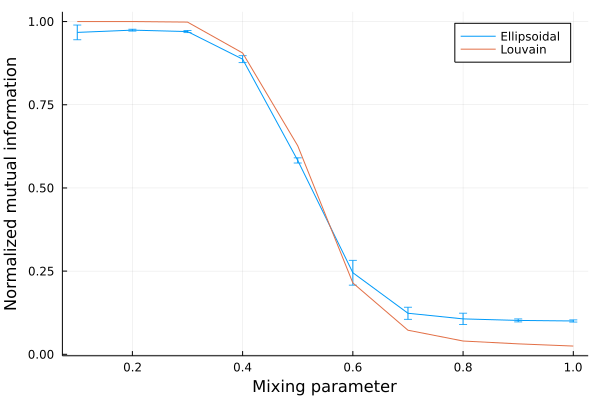

In [2]:
## Compute NMI for each graph

path="LFR_data/"
n_graphs=10

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain=readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes=size(community_true)[1]
    n_edges=size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj);
    
    community_true=community_true[vertices]
    community_true=rename_com_unique(community_true)
    
    community_louvain=community_louvain[vertices]
    community_louvain=rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
    mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
    mus[g]=mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[g,j]=mutualinfo(community_true,community);
    end
    NMIs_louvain[g]=mutualinfo(community_true,community_louvain);
end

#######################################################################
# Plot Normalized mutual information vs Miwing parameter
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("./nmi_vs_mu.pdf")
plot!()
#######################################################################

### Test impact of d0

mu=0.4
========== d0 step 1/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 312 iterations
  0.292805 seconds (8.28 k allocations: 219.137 MiB, 18.23% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 10
Number of communities: 12
Modularity: 487.6259072705852
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21982533090757725, 0.2126175452074654, 0.1810372742732658, 0.12823309253149706, 0.09870817130410185]
 -------------------------------------------- 
  0.514254 seconds (283.36 k allocations: 386.410 MiB, 13.09% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 279 iterations
  0.243401 seconds (7.43 k allocations: 195.910 MiB, 12.28% gc time)
 -------------- Clustering ------- 
dimension of embedding used fo

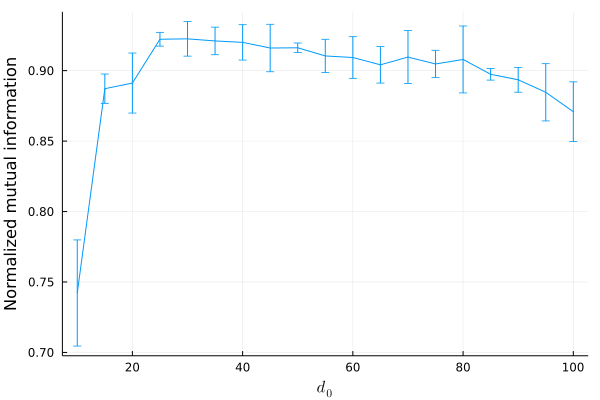

In [3]:
g=4

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
d0s = 10:5:100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(d0s),n_rep)

# load communities
community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes=size(community_true)[1]
n_edges=size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true=community_true[vertices]
community_true=rename_com_unique(community_true)

# load parameters
LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(d0s)
    println("\n========== d0 step $i/$(length(d0s)) ==========")
    d0=d0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j]=mutualinfo(community_true,community);
    end
end

#######################################################################
# Plot Normalized mutual information vs d0
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(d0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"d_0",
ylabel = "Normalized mutual information",
legend = false)

savefig("./nmi_vs_d0__mu"*string(mu)*".pdf")
plot!()
#######################################################################

### Test impact of n_clusters

mu=0.4
========== n_clusters step 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 155 iterations
  1.385583 seconds (4.35 k allocations: 1.048 GiB, 11.35% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 16
Number of communities: 10
Modularity: 649.1123585343884
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21999889829954788, 0.21263278015755074, 0.18103914128039694, 0.12826272925473056, 0.09871754817227435]
 -------------------------------------------- 
  1.764156 seconds (351.88 k allocations: 1.246 GiB, 10.89% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 214 iterations
  2.029280 seconds (5.95 k allocations: 1.449 GiB, 9.79% gc time)
 -------------- Clustering ------- 
dimension of embedding use

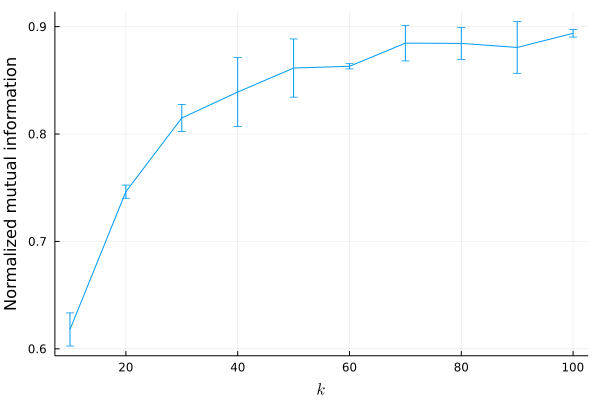

In [4]:
g=4

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters_list = 10:10:100;
d0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes=size(community_true)[1]
n_edges=size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true=community_true[vertices]
community_true=rename_com_unique(community_true)

# load parameters
LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters=n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,d0)

        NMIs[i,j]=mutualinfo(community_true,community);
    end
end

#######################################################################
# Plot Normalized mutual information vs d0
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = L"k",
ylabel = "Normalized mutual information",
legend = false)

savefig("./nmi_vs_nclusters__mu"*string(mu)*".pdf")
plot!()
#######################################################################